## XAI Bias Detection 

**Problem Statement**

Machine learning models used in high-stakes applications often inherit biases from historical data, 
leading to unfair decisions across demographic groups. Since most models operate as black boxes, 
identifying and understanding the causes of such bias is challenging. 
Existing approaches mainly quantify bias without explaining it. Therefore, there is a need for an XAI-based bias detection system that can detect, quantify, and explain biased model behavior to support fair and ethical AI deployment.

**Objectives**
- To detect and analyze bias in machine learning models used for decision-making tasks.
- To quantify fairness violations using standard bias and fairness metrics.
- To apply Explainable Artificial Intelligence (XAI) techniques to interpret model decisions and identify sources of bias.
- To provide transparent and human-interpretable explanations for biased predictions at both global and individual levels.
- To develop an interactive system that supports ethical, accountable, and trustworthy AI deployment.

## Dataset Description

The project utilizes the **Adult Census Income Dataset** sourced from the **UCI Machine Learning Repository**, a widely recognized benchmark dataset for research in machine learning fairness, bias detection, and ethical AI.

The dataset consists of demographic and socioeconomic information extracted from the **1994 U.S. Census**. Each record represents an individual and includes attributes such as age, education level, occupation, work class, marital status, race, gender, capital gain, capital loss, and hours worked per week. The objective is to predict whether an individual’s annual income exceeds **$50,000**.

The presence of sensitive attributes such as **gender (sex)** and **race** makes this dataset particularly suitable for studying algorithmic bias and fairness. In this project, **gender** is used as the primary sensitive attribute for bias detection and analysis.

Prior to model training, the dataset undergoes preprocessing steps including handling missing values, encoding categorical variables, and feature transformation. Due to its real-world origin and well-documented bias patterns, the Adult Census Income dataset serves as an effective benchmark for evaluating bias detection and explainability using **Explainable Artificial Intelligence (XAI)** techniques.

### Dataset Summary

| Attribute | Description |
|---------|-------------|
| Dataset Name | Adult Census Income |
| Source | UCI Machine Learning Repository |
| Total Instances | ~48,000 |
| Number of Features | 14 |
| Target Variable | Income (≤50K, >50K) |
| Sensitive Attributes | Gender, Race |
| Task Type | Binary Classification |


## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Bias / Fairness
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate,
    MetricFrame
)

# XAI
import shap
from lime.lime_tabular import LimeTabularExplainer

# Visualization
import matplotlib.pyplot as plt

# Model saving
import pickle


In [2]:
data = pd.read_csv(r"adult.csv")

data.sample(15)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
42742,27,Private,300783,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,42,United-States,>50K
21643,60,Private,224097,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
20972,56,Private,231232,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,30,Canada,<=50K
28491,33,Private,232475,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
23768,33,Private,278736,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,50,United-States,<=50K
48282,51,Local-gov,108435,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,80,United-States,>50K
5347,50,Private,139793,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,3418,0,38,United-States,<=50K
16858,36,Self-emp-not-inc,28738,Assoc-acdm,12,Divorced,Sales,Unmarried,White,Female,0,0,35,United-States,<=50K
36471,36,State-gov,223020,Some-college,10,Divorced,Other-service,Unmarried,Black,Female,0,0,20,United-States,<=50K
32077,21,Private,223352,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,1055,0,30,United-States,<=50K


In [3]:
data.shape

(48842, 15)

In [4]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [5]:
data.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [9]:
# Handle missing values
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)

# Encode target variable
data["income"] = data["income"].map({"<=50K": 0, ">50K": 1})

# Define sensitive attribute
sensitive_feature = data["gender"]

# Split features and target
x = data.drop(columns=["income"])
y = data["income"]


In [10]:
categorical_cols = x.select_dtypes(include="object").columns
numerical_cols = x.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

x_processed = preprocessor.fit_transform(x)

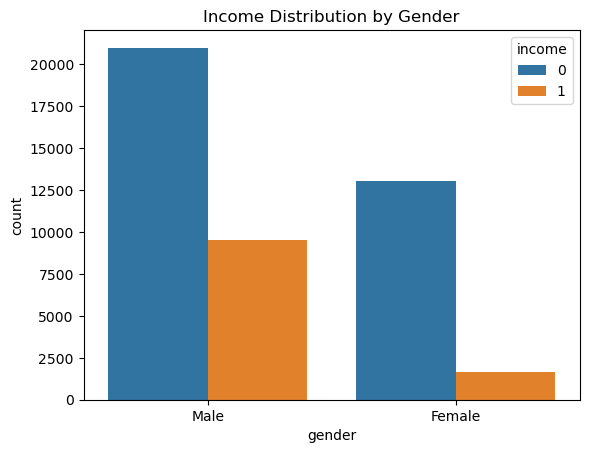

In [11]:
sns.countplot(x="gender", hue="income", data=data)
plt.title("Income Distribution by Gender")
plt.show()

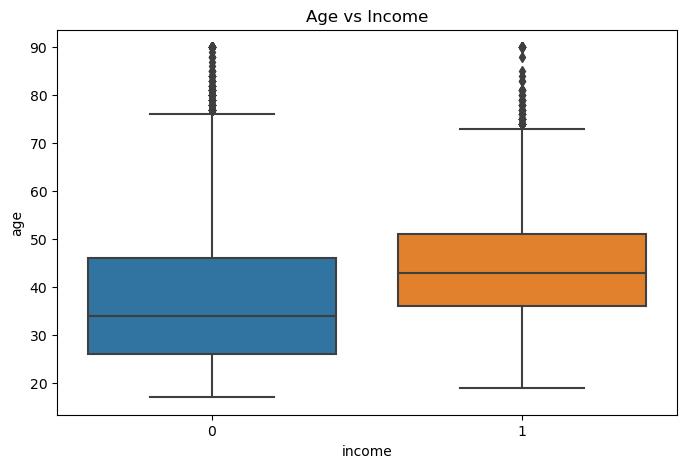

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x="income", y="age", data=data)
plt.title("Age vs Income")
plt.show()

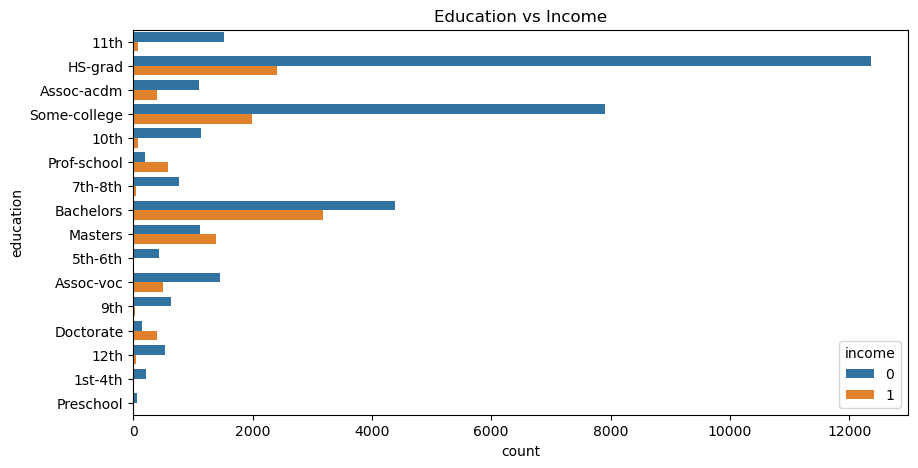

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(y="education", hue="income", data=data)
plt.title("Education vs Income")
plt.show()

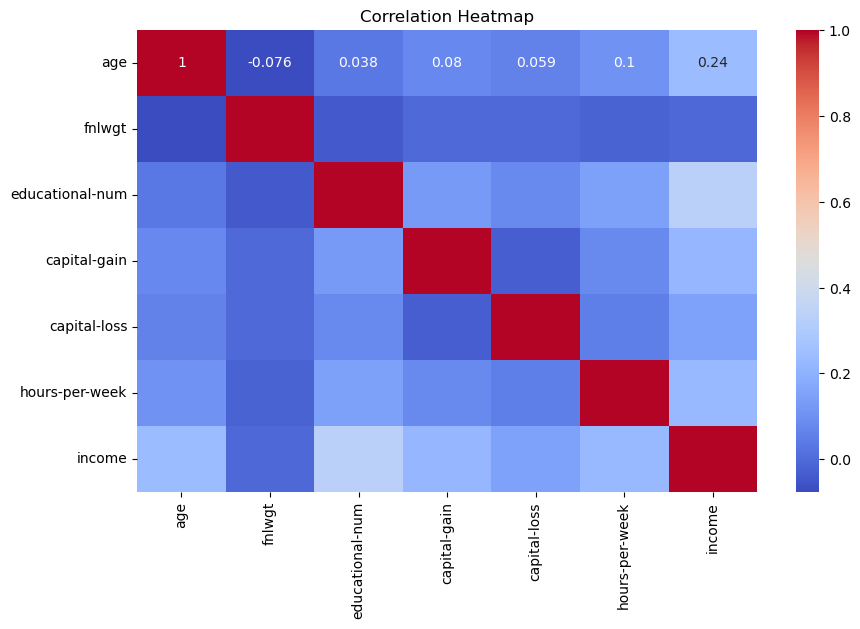

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(
    data.select_dtypes(exclude="object").corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Heatmap")
plt.show()

**Scaling**

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
x_scaled = scaler.fit_transform(x_processed)


## PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="arpack")
x_pca = pca.fit_transform(x_scaled)


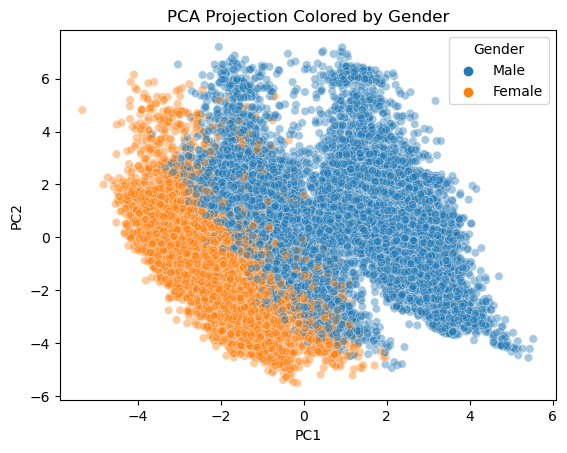

In [17]:
pca_df = pd.DataFrame({
    "PC1": x_pca[:, 0],
    "PC2": x_pca[:, 1],
    "Gender": sensitive_feature.values,
    "Income": y.values
})

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Gender", alpha=0.4)
plt.title("PCA Projection Colored by Gender")
plt.show()

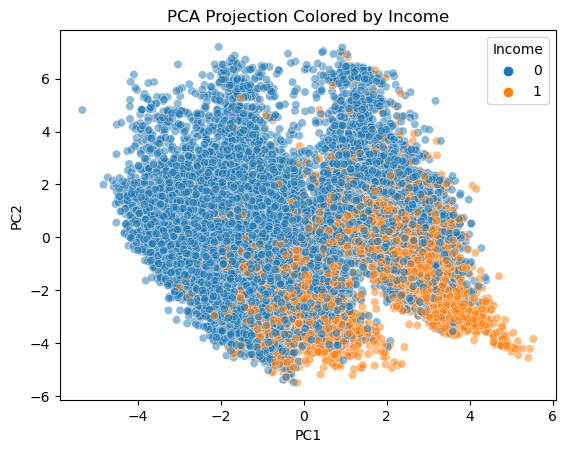

In [18]:
pca_df = pd.DataFrame({
    "PC1": x_pca[:, 0],
    "PC2": x_pca[:, 1],
    "Income": y.values
})

sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Income",
    alpha=0.5
)
plt.title("PCA Projection Colored by Income")
plt.show()

## Model Building

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    x_pca,
    y,
    sensitive_feature,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Import Classification Models**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


*Logistic Regression*

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
lr.fit(x_train, y_train)

lr_pred = lr.predict(x_test)

print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, lr_pred))
print("F1-Score :", f1_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

Logistic Regression
Accuracy : 0.8100608070757325
F1-Score : 0.5594871794871795
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6803
           1       0.66      0.49      0.56      2242

    accuracy                           0.81      9045
   macro avg       0.75      0.70      0.72      9045
weighted avg       0.80      0.81      0.80      9045



*K-Nearest Neighbors (KNN)*

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

knn_pred = knn.predict(x_test)

print("KNN")
print("Accuracy :", accuracy_score(y_test, knn_pred))
print("F1-Score :", f1_score(y_test, knn_pred))


KNN
Accuracy : 0.7982310668877833
F1-Score : 0.5607701564380265


*Naive Bayes*

In [25]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)

nb_pred = nb.predict(x_test)

print("Naive Bayes")
print("Accuracy :", accuracy_score(y_test, nb_pred))
print("F1-Score :", f1_score(y_test, nb_pred))


Naive Bayes
Accuracy : 0.8072968490878939
F1-Score : 0.5745667561630461


*Support Vector Machine (SVM)*

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True)
svm.fit(x_train, y_train)

svm_pred = svm.predict(x_test)

print("SVM")
print("Accuracy :", accuracy_score(y_test, svm_pred))
print("F1-Score :", f1_score(y_test, svm_pred))


SVM
Accuracy : 0.8177998894416805
F1-Score : 0.5560344827586207


*Decision Tree*

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)

dt_pred = dt.predict(x_test)

print("Decision Tree")
print("Accuracy :", accuracy_score(y_test, dt_pred))
print("F1-Score :", f1_score(y_test, dt_pred))


Decision Tree
Accuracy : 0.7587617468214484
F1-Score : 0.5140311804008909


*Random Forest*

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

rf_pred = rf.predict(x_test)

print("Random Forest")
print("Accuracy :", accuracy_score(y_test, rf_pred))
print("F1-Score :", f1_score(y_test, rf_pred))


Random Forest
Accuracy : 0.7955776672194582
F1-Score : 0.557125748502994


*Gradient Boosting*

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)

gb_pred = gb.predict(x_test)

print("Gradient Boosting")
print("Accuracy :", accuracy_score(y_test, gb_pred))
print("F1-Score :", f1_score(y_test, gb_pred))


Gradient Boosting
Accuracy : 0.8169154228855722
F1-Score : 0.571206628689798


## Comparision Table

In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score

accuracy_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "K-Nearest Neighbors",
        "Naive Bayes",
        "Support Vector Machine",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting"
    ],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, knn_pred),
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, svm_pred),
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, gb_pred)
    ]
})

accuracy_df

,Model,Accuracy
0,Logistic Regression,0.810061
1,K-Nearest Neighbors,0.798231
2,Naive Bayes,0.807297
3,Support Vector Machine,0.817800
4,Decision Tree,0.758762
5,Random Forest,0.795578
6,Gradient Boosting,0.816915


## Fairness Metrics

In [31]:
y_pred_lr = lr.predict(x_test)
y_prob_lr = lr.predict_proba(x_test)[:, 1]

In [32]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame,
    selection_rate
)

metrics = {
    "Selection Rate": selection_rate
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_lr,
    sensitive_features=s_test
)

print("Selection Rate by Gender:")
print(mf.by_group)

print("\nDemographic Parity Difference:",
      demographic_parity_difference(y_test, y_pred_lr, sensitive_features=s_test))

print("Equalized Odds Difference:",
      equalized_odds_difference(y_test, y_pred_lr, sensitive_features=s_test))


Selection Rate by Gender:
        Selection Rate
gender                
Female        0.020562
Male          0.260813

Demographic Parity Difference: 0.24025076703493217
Equalized Odds Difference: 0.41956406681357084


## SHAP – Global Bias Explanation

In [33]:
import shap

explainer = shap.Explainer(lr, x_train)
shap_values = explainer(x_test)


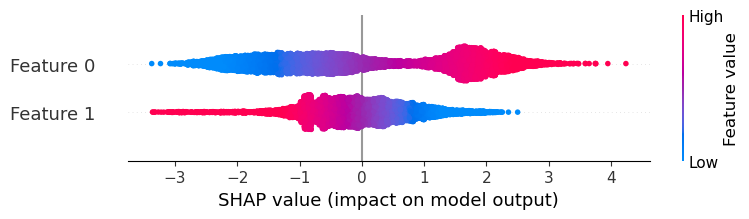

In [34]:
shap.summary_plot(shap_values, x_test)

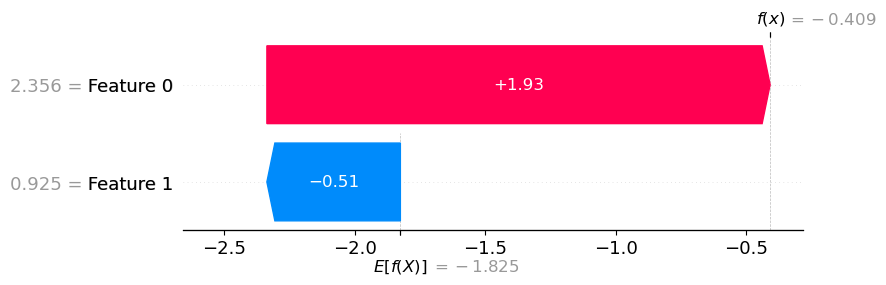

In [35]:
shap.plots.waterfall(shap_values[0])


## Bias Visualization Using PCA + SHAP

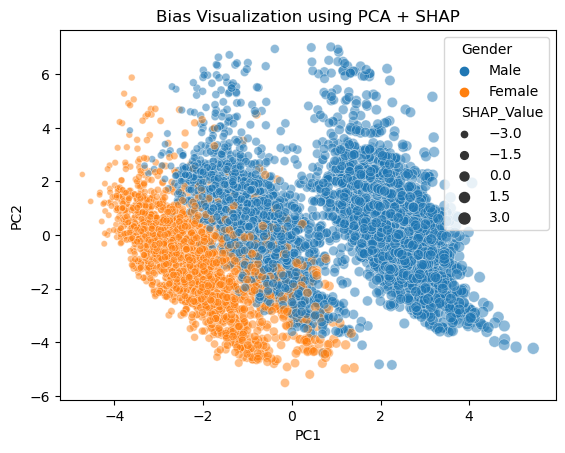

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

shap_df = pd.DataFrame({
    "PC1": x_test[:, 0],
    "PC2": x_test[:, 1],
    "SHAP_Value": shap_values.values[:, 0],
    "Gender": s_test.values
})

sns.scatterplot(
    data=shap_df,
    x="PC1",
    y="PC2",
    hue="Gender",
    size="SHAP_Value",
    alpha=0.5
)
plt.title("Bias Visualization using PCA + SHAP")
plt.show()


## LIME Setup

In [39]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    training_data=x_train,
    feature_names=["PC1", "PC2"],
    class_names=["<=50K", ">50K"],
    mode="classification"
)


In [40]:
lime_exp = lime_explainer.explain_instance(
    x_test[0],
    lr.predict_proba
)

lime_exp.show_in_notebook()


## Bias Comparison Across Models


In [41]:
models_preds = {
    "LR": lr_pred,
    "RF": rf_pred,
    "GB": gb_pred
}

for name, preds in models_preds.items():
    dp = demographic_parity_difference(
        y_test, preds, sensitive_features=s_test
    )
    print(f"{name} Demographic Parity Difference: {dp:.3f}")


LR Demographic Parity Difference: 0.240
RF Demographic Parity Difference: 0.245
GB Demographic Parity Difference: 0.225


## Conclusion

This project presented an end-to-end XAI-based bias detection framework for machine learning models using a real-world dataset. Exploratory data analysis revealed demographic imbalance, indicating a high risk of biased predictions. Multiple classification models were trained and evaluated, showing that higher accuracy does not necessarily imply fairness.

Bias was quantitatively measured using standard fairness metrics, which confirmed disparities in predictions across sensitive groups. To overcome the lack of transparency in traditional models, Explainable AI (XAI) techniques were applied. SHAP and LIME provided both global and local explanations, clearly identifying the factors contributing to biased decisions.

Overall, the study demonstrates that integrating fairness metrics with XAI enables transparent, interpretable, and ethical evaluation of machine learning models. The proposed approach improves trust and accountability in AI systems and is suitable for deployment in high-stakes, real-world applications.

In [43]:
import pickle

pickle.dump(
    {
        "Logistic Regression": lr,
        "Random Forest": rf,
        "Gradient Boosting": gb
    },
    open("xai_bias_model.pkl", "wb")
)
print("Model artifacts saved successfully")

Model artifacts saved successfully
